# Notebook for statistical analysis of the climate produced by the GAN. 

This notebook describes how to produce the figures in the article [Producing realistic climate data using GAN](https://npg.copernicus.org/articles/28/347/2021/npg-28-347-2021.html)

One should note that this repository shows the code but due to the size of the dataset the figures were reproduced with reduced dataset. Consequently, the quality of the statistical analysis is impacted. Data were created by running the Plasim simulator, for further details see the article. 

The dataset is composed of the daily images of different variable (temperature, wind components, humidity...) on a 64 by 128 pixel grid with 10 levels of altitude over the globe, projected using the PlateCarre projection. These images were standardized with respect to each variable and each level of altitude, the mean and std are stored in the "scaling" dataset.  

In [79]:
#Import of necessary packages and memory allocation.

%matplotlib inline
import tensorflow as tf
import keras 
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
#config.gpu_options.visible_device_list = str(3)
set_session(tf.Session(config=config))

import h5py as h5
import pandas as pd
from keras.models import load_model
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.util
import sys
import seaborn as sns
import math
#s = np.random.seed(1)

2022-05-18 09:09:12.021402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 09:09:12.021825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3070 major: 8 minor: 6 memoryClockRate(GHz): 1.755
pciBusID: 0000:06:00.0
2022-05-18 09:09:12.021991: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Could not dlopen library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/usr/local/cuda-11.3/lib64
2022-05-18 09:09:12.022036: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Could not dlopen library 'libcublas.so.10.0'; dlerror: libcublas.so.10.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib

In [80]:
#Plot parameters.
from matplotlib import rc
sns.set() #Seaborn theme 
font = {'family' : 'normal','weight' : 'bold', 'size'   : 22}
tick_size = 20
fontweight = 'bold'
matplotlib.rc('font', **font)
plt.style.use('seaborn')

In [81]:
# Paths

data_file = 'data_plasim_3y_sc.h5' # Dataset filename 

## Notebook parameters. 

Setting up parameters for :
  - Figure generation
  - Number of samples considered for the statistical analysis (Here very low for computational purpose)
  - Longitude and latitude of grid cells
  - Different names of the 

In [82]:
#########
multi_train = True  # If the training was in multiple run : True
plot_var = True     # True: plot all cells result ; False : manualy change if plot_var in if True: to plot
save = False         
scale = False
#########
N_fields = 82      #Number of fields == Number of channels in generated tensor. 
N_lvls = 10         #Number of pressure level for 3D variable. 

N_gen = 365     #Number of generation used for statistic analysis /!\ Memory usage important /!\
N_train = 365

#indxs = np.random.randint(0,1000,N_gen)
#ind = indxs[0]
#########
lons = np.genfromtxt('../data/raw/lon.csv', delimiter=',')
lat = np.genfromtxt('../data/raw/lat.csv', delimiter=',')

print(lons)
lon_idx = [16,16,32,48]                    #France, north america, ecuador, south america
lat_idx = [5,106,106,106]                  #France, north america, ecuador, south america
fnes = [[16,5],[16,106],[32,106],[48,106]] #Coordinate for distribution comparison at different locations.
L_ind = ['a','b','c','d']


if N_fields==82:
    runnumber_0 = 'RESNET_V8_82l'
    runnumber_1, stop1 = 'RESNET_V8_82l_continue1', 8000 #Name of the generator save file for the 1st restart
    runnumber_2, stop2 = 'RESNET_V8_82l_continue2', 15500 #Name of the generator save file for the 2nd restart
    runnumber_3, stop3 = 'RESNET_V8_82l_continue3b', 23250
    runnumber_4, stop4 = 'RESNET_V8_82l_continue4', 31000
    runnumber = runnumber_4 #Most recent save

[  0.       2.8125   5.625    8.4375  11.25    14.0625  16.875   19.6875
  22.5     25.3125  28.125   30.9375  33.75    36.5625  39.375   42.1875
  45.      47.8125  50.625   53.4375  56.25    59.0625  61.875   64.6875
  67.5     70.3125  73.125   75.9375  78.75    81.5625  84.375   87.1875
  90.      92.8125  95.625   98.4375 101.25   104.0625 106.875  109.6875
 112.5    115.3125 118.125  120.9375 123.75   126.5625 129.375  132.1875
 135.     137.8125 140.625  143.4375 146.25   149.0625 151.875  154.6875
 157.5    160.3125 163.125  165.9375 168.75   171.5625 174.375  177.1875
 180.     182.8125 185.625  188.4375 191.25   194.0625 196.875  199.6875
 202.5    205.3125 208.125  210.9375 213.75   216.5625 219.375  222.1875
 225.     227.8125 230.625  233.4375 236.25   239.0625 241.875  244.6875
 247.5    250.3125 253.125  255.9375 258.75   261.5625 264.375  267.1875
 270.     272.8125 275.625  278.4375 281.25   284.0625 286.875  289.6875
 292.5    295.3125 298.125  300.9375 303.75   306.5

Here _X_train has a size of (samples, latitude, longitudes, variable). Variable has a size of 82 due to the different variables at differents altitude levels. Below the name of the different channels are printed : ta_z100 is for example the temperature at the pressure level 100 hPa i.e. at the surface. There is 8 different variables on the 10 pressure levels plus the surface pressure.  

In [83]:
# Loading dataset and scaling factors (N_fields, 2)= mean and variance for each channel.

if N_fields==82:
    f=h5.File(f'../data/raw/{data_file}','r')
    _X_train = f['dataset']
    scaling = f['scaling'][:,:]
print(scaling.shape)

(81, 2)


In [84]:
if N_fields==82:
    var = ['ta', 'ua', 'va', 'hus', 'wap', 'zeta', 'd', 'zg']
    lvls = [100, 200,300,400,500,600,700,800,900,1000]

chan_titles = []
for i in var:
    for j in lvls:
        chan_titles.append(i+'_z'+str(j))
chan_titles.append('surface pressure')
#chan_titles.append('latitude')

print(chan_titles)

['ta_z100', 'ta_z200', 'ta_z300', 'ta_z400', 'ta_z500', 'ta_z600', 'ta_z700', 'ta_z800', 'ta_z900', 'ta_z1000', 'ua_z100', 'ua_z200', 'ua_z300', 'ua_z400', 'ua_z500', 'ua_z600', 'ua_z700', 'ua_z800', 'ua_z900', 'ua_z1000', 'va_z100', 'va_z200', 'va_z300', 'va_z400', 'va_z500', 'va_z600', 'va_z700', 'va_z800', 'va_z900', 'va_z1000', 'hus_z100', 'hus_z200', 'hus_z300', 'hus_z400', 'hus_z500', 'hus_z600', 'hus_z700', 'hus_z800', 'hus_z900', 'hus_z1000', 'wap_z100', 'wap_z200', 'wap_z300', 'wap_z400', 'wap_z500', 'wap_z600', 'wap_z700', 'wap_z800', 'wap_z900', 'wap_z1000', 'zeta_z100', 'zeta_z200', 'zeta_z300', 'zeta_z400', 'zeta_z500', 'zeta_z600', 'zeta_z700', 'zeta_z800', 'zeta_z900', 'zeta_z1000', 'd_z100', 'd_z200', 'd_z300', 'd_z400', 'd_z500', 'd_z600', 'd_z700', 'd_z800', 'd_z900', 'd_z1000', 'zg_z100', 'zg_z200', 'zg_z300', 'zg_z400', 'zg_z500', 'zg_z600', 'zg_z700', 'zg_z800', 'zg_z900', 'zg_z1000', 'surface pressure']


## Generator loading

In the following cells the trained generator of the GAN model is loaded. The custom_objects parameter is the custom layers inside the generator that needs to be redefine at the loading. 

In [85]:
sys.path.append('../src/modeling')
sys.path.append('../src/preprocessing')
sys.path.append('../src/preparation')

from SpectralNormalizationKeras import ConvSN2D, DenseSN
from custom_classes import NearestPadding2D, WrapPadding2D
#from data_preproc import *

gen = load_model(f'../model/{runnumber}_generator.h5',
                 custom_objects = {'NearestPadding2D': NearestPadding2D,
                                   'WrapPadding2D': WrapPadding2D, 
                                   'DenseSN' :DenseSN, 
                                   'ConvSN2D': ConvSN2D})


/home/besombes/.env/old_tf1/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Data loading

Now that the dataset and the generator are loaded, N_gen samples are generated by the generator and N_train samples are loaded from the dataset to begin the statistical comparison. The differents samples are rescaled.

In [86]:
print('Generating samples...')

z = np.random.normal(0,1,(N_gen,64))
fk_imgs = gen.predict(z)
print('Samples generated.')
print('scaling...')
fk_imgs = np.multiply(fk_imgs[:,:,:,:-1],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('scaled.')

print('Scaling...')
X_train = np.multiply(_X_train[:N_train,:,:,:],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('Scaled')

Generating samples...
Samples generated.
scaling...
scaled.
Scaling...
Scaled


## Local statistics

Now the different histogram of variables at certain grid cell is compared between the dataset and the generated data. 

In [87]:
data = {}

X_fr = X_train[:,16,127,:] # Load the data from the dataset at a particular grid cell.
for chan in range(81):
    data[chan_titles[chan]] = X_fr[:,chan]

In [88]:
start = pd.to_datetime("01-01-2012")
idx = pd.date_range(start, periods= N_train, freq='D')
df_local = pd.DataFrame(data = data, index = idx) 
df_local.index = idx
df_local

,ta_z100,ta_z200,ta_z300,ta_z400,ta_z500,ta_z600,ta_z700,ta_z800,ta_z900,ta_z1000,...,zg_z200,zg_z300,zg_z400,zg_z500,zg_z600,zg_z700,zg_z800,zg_z900,zg_z1000,surface pressure
2012-01-01,212.950607,220.553741,230.696518,236.969070,245.781982,254.463150,262.214874,268.894562,275.796967,282.115692,...,11859.603516,9112.725586,7105.867188,5498.488770,4133.355957,2980.639160,1937.365723,987.295105,121.284927,11.457537
2012-01-02,209.863541,224.635666,232.952805,243.529541,251.801941,256.549255,259.994843,265.375214,273.380280,279.815887,...,12034.112305,9245.954102,7202.084961,5547.182617,4158.581055,3010.929932,1979.020508,1039.845093,180.074005,11.464328
2012-01-03,211.516602,224.758286,234.257828,242.328201,250.416260,257.939392,264.531647,270.000946,275.278259,280.872620,...,12070.541992,9275.007812,7229.173828,5584.678223,4200.958008,3034.307861,1983.609741,1032.155518,168.274963,11.463063
2012-01-04,212.815079,220.636292,229.014954,241.696091,252.493271,259.798492,264.350677,267.933716,272.633270,278.801392,...,12051.819336,9312.162109,7293.685059,5642.680176,4251.557617,3080.671143,2033.113770,1090.477539,232.736816,11.470659
2012-01-05,212.407394,218.986847,228.610382,242.980408,252.370255,260.467224,267.451172,272.082520,275.873566,281.759827,...,12070.968750,9345.198242,7323.760742,5664.975586,4275.567871,3094.541504,2033.009888,1077.025513,209.817108,11.468304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-26,209.495483,216.868774,228.273804,242.888336,253.786179,261.990234,268.358978,273.396851,277.856964,283.802917,...,12012.225586,9303.536133,7285.544434,5627.696777,4215.891602,3033.392334,1967.914917,1005.594971,133.403107,11.459342
2012-12-27,209.900452,215.276947,225.788834,240.361664,251.420853,260.080414,267.151062,272.982147,276.992615,282.962433,...,11999.769531,9315.172852,7317.608398,5673.796875,4286.999023,3108.480225,2045.797974,1086.496948,215.440872,11.469178
2012-12-28,206.397720,212.980499,231.020248,246.653061,256.477234,264.231842,272.199219,280.816101,279.349365,283.591888,...,12209.384766,9513.836914,7465.126465,5778.879395,4370.069824,3173.098145,2083.665527,1105.391235,230.362854,11.471088
2012-12-29,204.506744,213.162079,234.404221,248.070984,259.229614,266.885040,272.885590,279.161102,277.685669,282.597839,...,12267.087891,9552.108398,7480.934082,5785.791504,4356.160645,3152.931396,2065.121582,1092.491699,221.435440,11.469852


Text(0.5, 1.0, 'Example of a timeseries of the temperature at 100 hPa from the data for one year.')

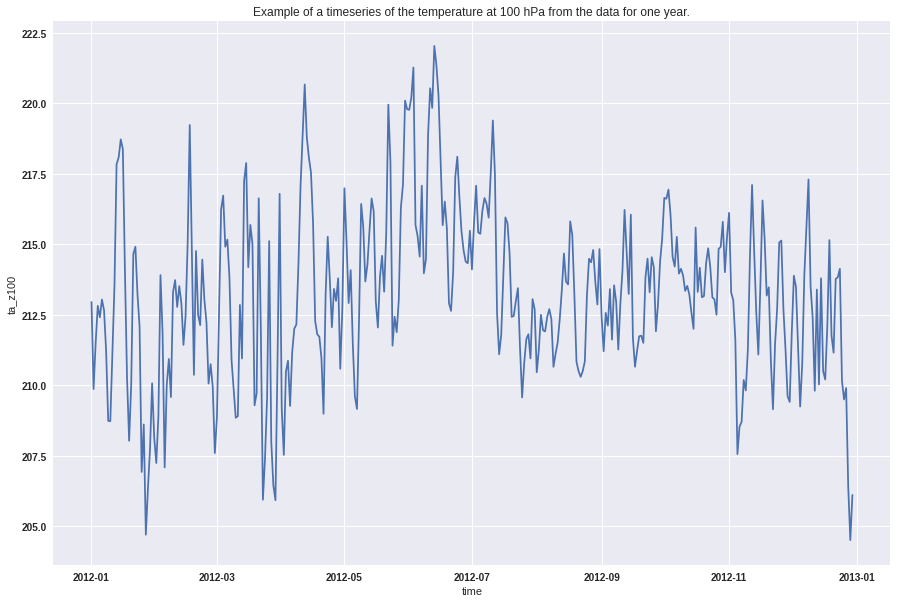

In [89]:
plt.figure(figsize=(15,10))
sns.lineplot(y=chan_titles[0], x=idx, data=df_local)
plt.xlabel('time')
plt.title('Example of a timeseries of the temperature at 100 hPa from the data for one year.')

/home/besombes/.env/old_tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


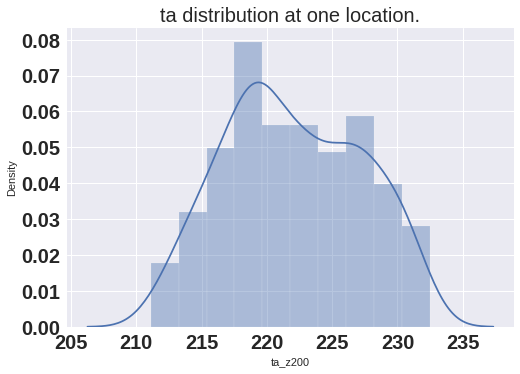

In [90]:
title = 'ta_z200'

for chan in chan_titles[:1]:
    fig, ax = plt.subplots()
    
    #df_local.plot(y = chan, ax = ax, kind = 'hist')
    pl = sns.distplot(df_local[title])
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    pl.axes.set_title(f'{title[:-5]} distribution at one location.', fontsize = 20)
    #df_local.plot(x = chan_titles[5+i], y = chan_titles[10+i], kind = 'boxplot', ax = ax)

In [91]:
def locDist(X, var2plot, px_idx = (0,0), chan_titles = None, plot=True):
    """Returns a dataframe of specified variable at the specifed pixel indices."""
    
    data = {}
    X_loc = X[:,px_idx[0],px_idx[1],:]
    
    for chan in range(N_fields-1):
        data[chan_titles[chan]] = X_loc[:,chan]
        
    start = pd.to_datetime("27-9-2012")
    idx = pd.date_range(start, periods= X.shape[0])
    df_local = pd.DataFrame(data = data, index = idx) 
    df_local.index = idx
    
    if plot:
        for chan in var2plot:
            fig, ax = plt.subplots()
            sns.distplot(df_local[var2plot[0]])

    return df_local

def locDist2(X1, X2, var2plot, px_idx = (0,0), chan_titles=None, plot=True, save=None):
    """Returns a dataframe of specified variables at the specificed location for two different
    dataset. If plot=True plots the distributions of the variables on the same plot.
    """
    df_local1 = locDist(X1, var2plot, px_idx=px_idx, chan_titles=chan_titles, plot=False)
    df_local2 = locDist(X2, var2plot, px_idx=px_idx, chan_titles=chan_titles, plot=False)
    
    if plot:
        for chan in var2plot:
            fig, ax = plt.subplots(figsize=(16,9))
            plt.suptitle(f'Comparison of {var2plot[0]} distribution at one pixel : \n'
                         f'{px_idx} between database and generations.',
                         fontsize = 24, fontweight = fontweight)

            fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.1, hspace = 0.3)

            plt.subplot(1,1,1)
            sns.distplot(df_local1[var2plot[0]], rug=False, hist=True, kde = True,
                         norm_hist = False, color = 'g', bins = None)


            sns.distplot(df_local2[var2plot[0]], rug=False, hist=True, kde = True,
                         norm_hist = False, color = 'b', bins = None)

            plt.xlabel(var2plot[0][:-5], fontsize = 20, fontweight = fontweight)
            plt.legend(['Database',"Generated" ], fontsize = 20)
            plt.tick_params(axis='both', labelsize=tick_size)
            if save != None:
                plt.savefig(f'./fig_{N_fields}c/{save}')
            
    return df_local1, df_local2



def maxDist(X, var2plot,  chan_titles = None):
    """Returns the max value among all the grid cells and all the samples for each variables"""
    
    data = {}
    for chan in range(N_fields-1):
        data[chan_titles[chan]] = np.amax(X[:,:,:,chan], axis = (1,2))
        
    df_local = pd.DataFrame(data = data) 
    
    for chan in var2plot:
        fig, ax = plt.subplots()

    sns.distplot(df_local[var2plot[0]])
    
    return df_local[var2plot[0]]



Distributions at different places of a particular variables is compared. The places were chosen to represent different latitudes which corresponds to different climates.

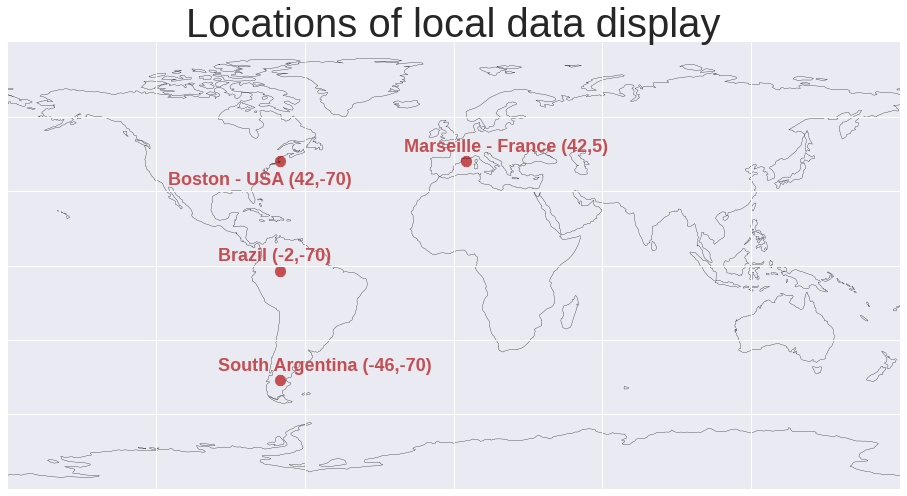

In [92]:
fig, ax = plt.subplots(figsize = (16,9), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0.)})
ax.coastlines(resolution='110m')
subtitle = ['Marseille - France (42,5)', 'Boston - USA (42,-70)', 'Brazil (-2,-70)', 'South Argentina (-46,-70)']

img = np.zeros((64,128))

lon_idx = [16,16,32,48] #France, north america, ecuador, south america
lat_idx = [5,106,106,106] ##France, north america, ecuador, south america

lat_ = [42,42,-2,-46] #France, north america, ecuador, south america
lon_ = [5,-70,-70,-70] ##France, north america, ecuador, south america


for i in range(4):
    for j in range(1):
        for k in range(1):
            img[lon_idx[i]-k, lat_idx[i]-j] = 1.
    if i ==1:
        ax.text(lon_[i]-45, lat_[i]-9, subtitle[i], color = 'r', fontsize = 18, transform=ccrs.PlateCarree())
    else:
        ax.text(lon_[i]-25, lat_[i]+4, subtitle[i], color = 'r', fontsize = 18, transform=ccrs.PlateCarree())

plt.scatter(lon_, lat_, s = 120, c='r', alpha = 1)
ax.gridlines()
ax.set_extent((-180,180,-90,90))
plt.title('Locations of local data display', fontsize = 40)

if save:
    plt.savefig(f'./fig_{N_fields}c/scatter_idx.pdf')

In [93]:
import scipy as scp
def locsDist(X1, var2plot=None, X2 = None, px_idx =[[16,5],[16,106],[32,106],[48,106]],
             chan_titles = None, save = None):
    """Plots the distribution of a given variable at different locations over the globe. It also computes 
    the Wasserstein distance between each pair of distribution."""
    
    if X2 is not None :
        N_samples = min(X1.shape[0], X2.shape[0])
    else:
         N_samples = X1.shape[0]
            
    leg = True
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15,12))
    fig.suptitle(f' Temperature distribution at different pixels.'
                            , fontsize = 24, fontweight = fontweight)
    fig.subplots_adjust(top = 0.87,left=0.1,right=.9,bottom=0.08, wspace = 0.16, hspace = 0.45)
    subtitle = ['(a) \n Marseille - France (42,5)', '(b) \n Boston - USA (42,-70)', '(c) \n Brazil (-2,-70)', '(d) \n South Argentina (-46,-70)']
    
    for i in range(len(px_idx)):
        data1 = {}
        X_loc1 = X1[:N_samples, px_idx[i][0], px_idx[i][1], :]
        
        if X2 is not None:
            data2 = {}
            X_loc2 = X2[:N_samples, px_idx[i][0], px_idx[i][1], :]

        for chan in range(21):
            data1[chan_titles[chan]] = X_loc1[:,chan]
            if X2 is not None:
                data2[chan_titles[chan]] = X_loc2[:,chan]

        start     = pd.to_datetime("27-9-2012")
        idx       = pd.date_range(start, periods= X1.shape[0])
        df_local1 = pd.DataFrame(data = data1)
        
        if X2 is not None:
            df_local2 = pd.DataFrame(data = data2)

        for chan in var2plot:
            ax = plt.subplot(2,2,i+1)
            sns.distplot(df_local1[var2plot[0]], rug=False, hist=True, kde = True,
                         norm_hist = False, color = 'g', bins = None)
            
            if X2 is not None:
                sns.distplot(df_local2[var2plot[0]], rug=False, hist=True, kde = True,
                             norm_hist = False, color = 'b', bins = None)
                wd_dist = scp.stats.wasserstein_distance((df_local1[var2plot[0]]-scaling[9,0])/scaling[9,1],
                                                         (df_local2[var2plot[0]]-scaling[9,0])/scaling[9,1])
                ax.set_title(f'{subtitle[i]} \n wasserstein distance : {wd_dist:.2}', fontsize = 20)
                if leg:
                    plt.legend(['database','generated'], fontsize = 15)
                    leg=False
            ax.set_xlabel(var2plot[0][:], fontsize = 20)
            plt.tick_params(axis='both', labelsize=15)
        
    if save != None:
        plt.savefig(f'./fig_{N_fields}c/{save}')
    return #df_local[var2plot[0]]

/home/besombes/.env/old_tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


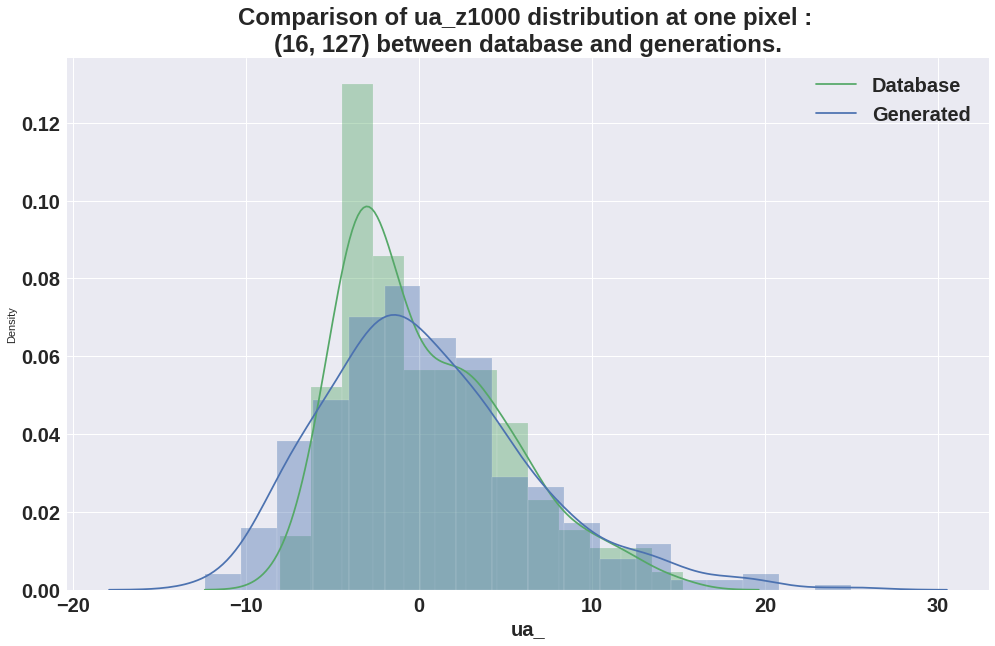

In [94]:
a3 = locDist2(X_train, fk_imgs, ['ua_z1000'], px_idx = (16,127), chan_titles = chan_titles)

/home/besombes/.env/old_tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(365, 64, 128, 81)


/home/besombes/.env/old_tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

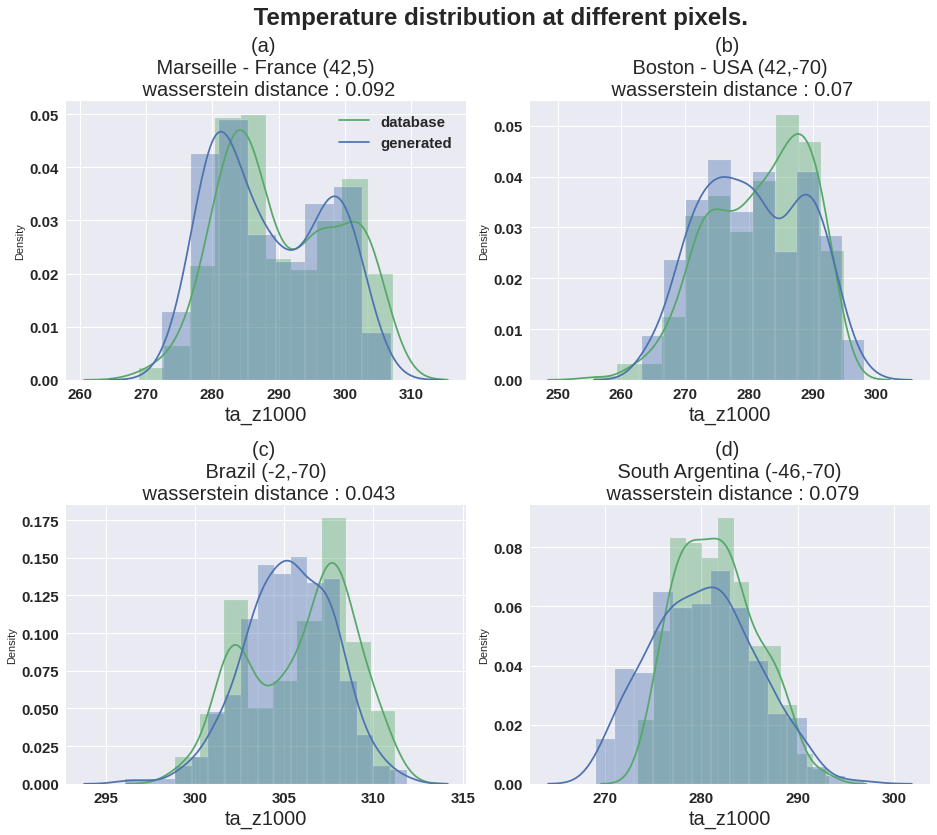

In [95]:
print(fk_imgs.shape)

#print(X_train[np.sort(np.random.randint(0,N_gen,N_gen)),:,:,:])
aaa = locsDist(X_train[:,:,:,:], X2 = fk_imgs[:,:,:,:],
               px_idx =[[16,5],[16,106],[32,106],[48,106]], var2plot=['ta_z1000'],
               chan_titles = chan_titles)
#print(aaa)

/home/besombes/.env/old_tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


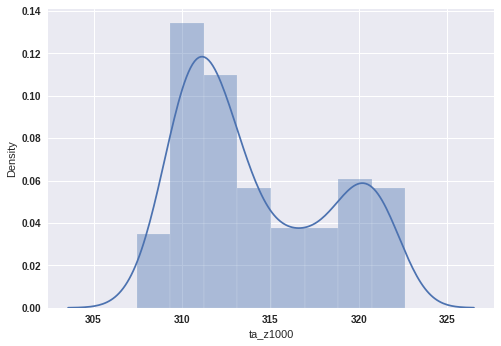

In [96]:
a = maxDist(X_train, ['ta_z1000'], chan_titles = chan_titles)

/home/besombes/.env/old_tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


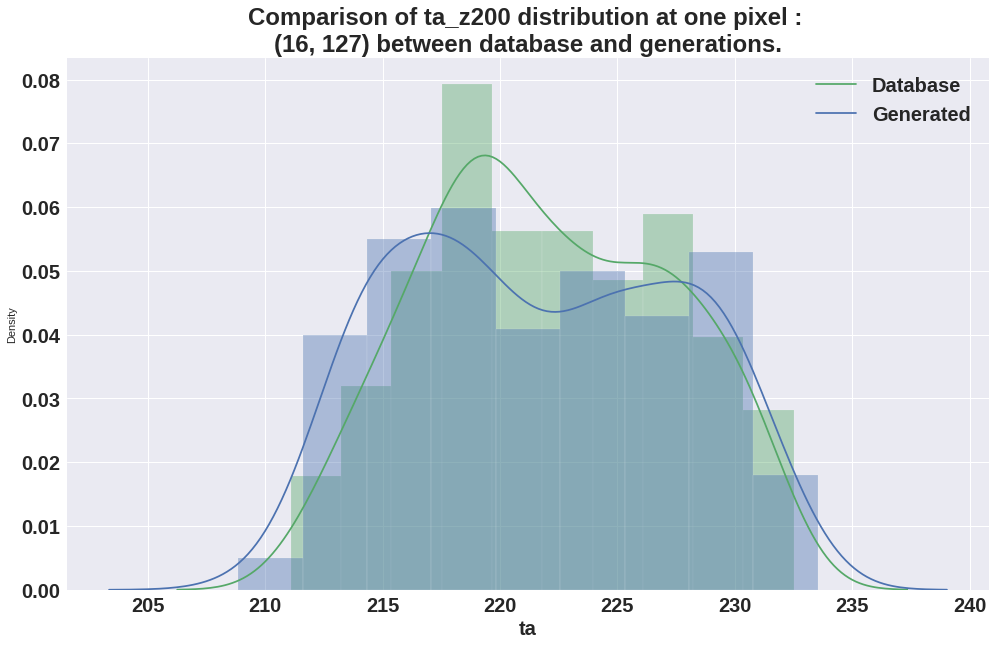

In [97]:
a3 = locDist2(X_train, fk_imgs, ['ta_z200'], px_idx = (16,127),
              chan_titles = chan_titles, save='temperature_z200_dist_comparisons.pdf')

More than local statistics, the correlation structures are important to compare in climate study. A variable at grid cell is chosen and the correlation with the other grid cells is computed. This is done for data from the dataset and generated, then the correlation structures are compared.

In [98]:
N = 350
channel_index = 25
print(X_train.shape)
dfc = pd.DataFrame(data = (X_train[:N,:,:,channel_index]).reshape(N,64*128), index = idx[:N])

(365, 64, 128, 81)


In [99]:
correl_db = dfc.corr()

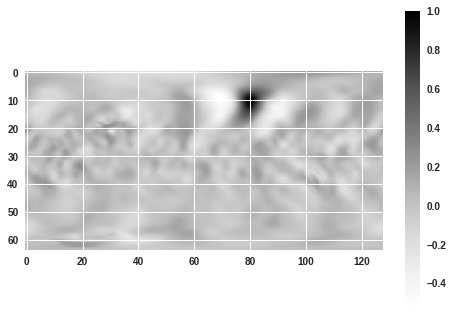

In [100]:
plt.imshow(correl_db[1360].values.reshape(64,128))
plt.colorbar()

In [101]:
print(fk_imgs.shape)
dfcfk = pd.DataFrame(data = (fk_imgs[:N,:,:,channel_index]*scaling[channel_index,1]+scaling[channel_index,0]).reshape(N,64*128), index = idx[:N]) 

(365, 64, 128, 81)


In [102]:
correl_gen = dfcfk.corr()

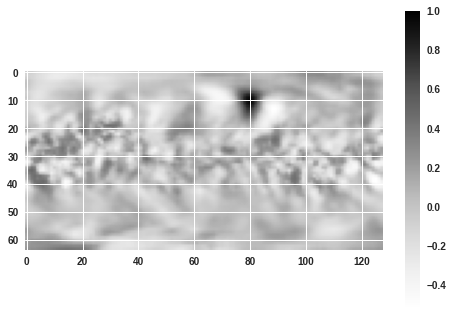

In [103]:
plt.imshow(correl_gen[1360].values.reshape(64,128))
plt.colorbar()


The GAN model optimize a loss function that corresponds to an approximation of the [Wasserstein distance](https://en.wikipedia.org/wiki/Wasserstein_metric). It is possible to compute this metric at each grid cell for each variable between the dataset and the generated data. 

In [104]:
import scipy as scp
def locDistwd(X1, X2, save=None):
    """Return the local wasserstein distance at each grid cell for each variable channels."""
    
    wd_im = np.zeros((64,128,N_fields-1))
    for i in range(64):
        for j in range(128):
            for k in range(N_fields-1):
                wd_im[i, j, k] = scp.stats.wasserstein_distance(X1[:,i,j,k], X2[:,i,j,k])
        print(i, end = ' ')
        if save != None:
            plt.savefig(f'./fig_22c/{save}')
    return wd_im

In [105]:
print(fk_imgs[:N_gen,:,:,:-1].shape)
print(X_train[:N_gen,:,:,:].shape)

wd_im = locDistwd(X_train[:N_gen,:,:,:], fk_imgs[:N_gen,:,:,:])

print(wd_im.shape)

(365, 64, 128, 80)
(365, 64, 128, 81)
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 (64, 128, 81)


In [106]:
imw = np.zeros((64,128,9))
for i in range(N_lvls-1):
    imw[:,:,i] = np.mean(wd_im[:,:,i*N_lvls:(i+1)*N_lvls], axis = -1)
imw[:,:,-1] = wd_im[:,:,-1]
print(imw.shape)

(64, 128, 9)


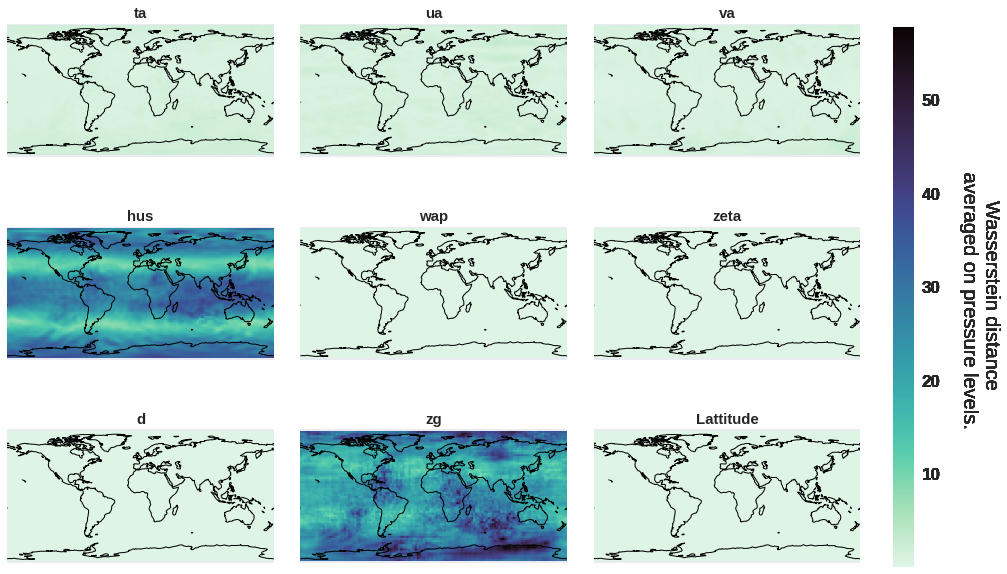

In [107]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(15,10),
                    subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
ax = ax.reshape(1,-1)
#fig.suptitle(f'Wasserstein distance for each fields \n averaged on pressure levels.', fontsize = 24, fontweight = fontweight)
fig.subplots_adjust(top = 0.9,left=0.01,right=0.8,bottom=0.08, wspace = 0.1, hspace = 0.1)

cbar_max = np.amax(imw)
cbar_min = np.amin(imw)   
cnt = 1
for k in range(8):
    ax[0,cnt-1].coastlines(linewidth = 1)
    im = ax[0,cnt-1].imshow(imw[::-1,:,k], cmap='mako_r', vmin=cbar_min, vmax=cbar_max,
                            transform=ccrs.PlateCarree(central_longitude=180.))
    
    ax[0,cnt-1].set_title(chan_titles[k*10][:-5], fontsize = 15, fontweight = fontweight)


    
    #ax[0,cnt-1].grid(False)
    cax = fig.add_axes([0.83, 0.11, 0.02, 0.75])
    fig.colorbar(im, cax, orientation='vertical')
    cax.tick_params(axis='both', which='major', labelsize=17)
    cax.set_ylabel('Wasserstein distance \n averaged on pressure levels.', rotation=270, fontsize = 20, labelpad=60)
    cnt+=1
ax[0,-1].coastlines(linewidth = 1)
im = ax[0,-1].imshow(imw[::-1,:,-1], cmap='mako_r', vmin=cbar_min, vmax=cbar_max,
                            transform=ccrs.PlateCarree(central_longitude=180.))
ax[0,-1].set_title('Lattitude', fontsize = 15, fontweight = fontweight)
if save:
    plt.savefig(f'./fig_{N_fields}c/wd_spatial_var.pdf')   

3.325808486687012e-08 188.23050685166436


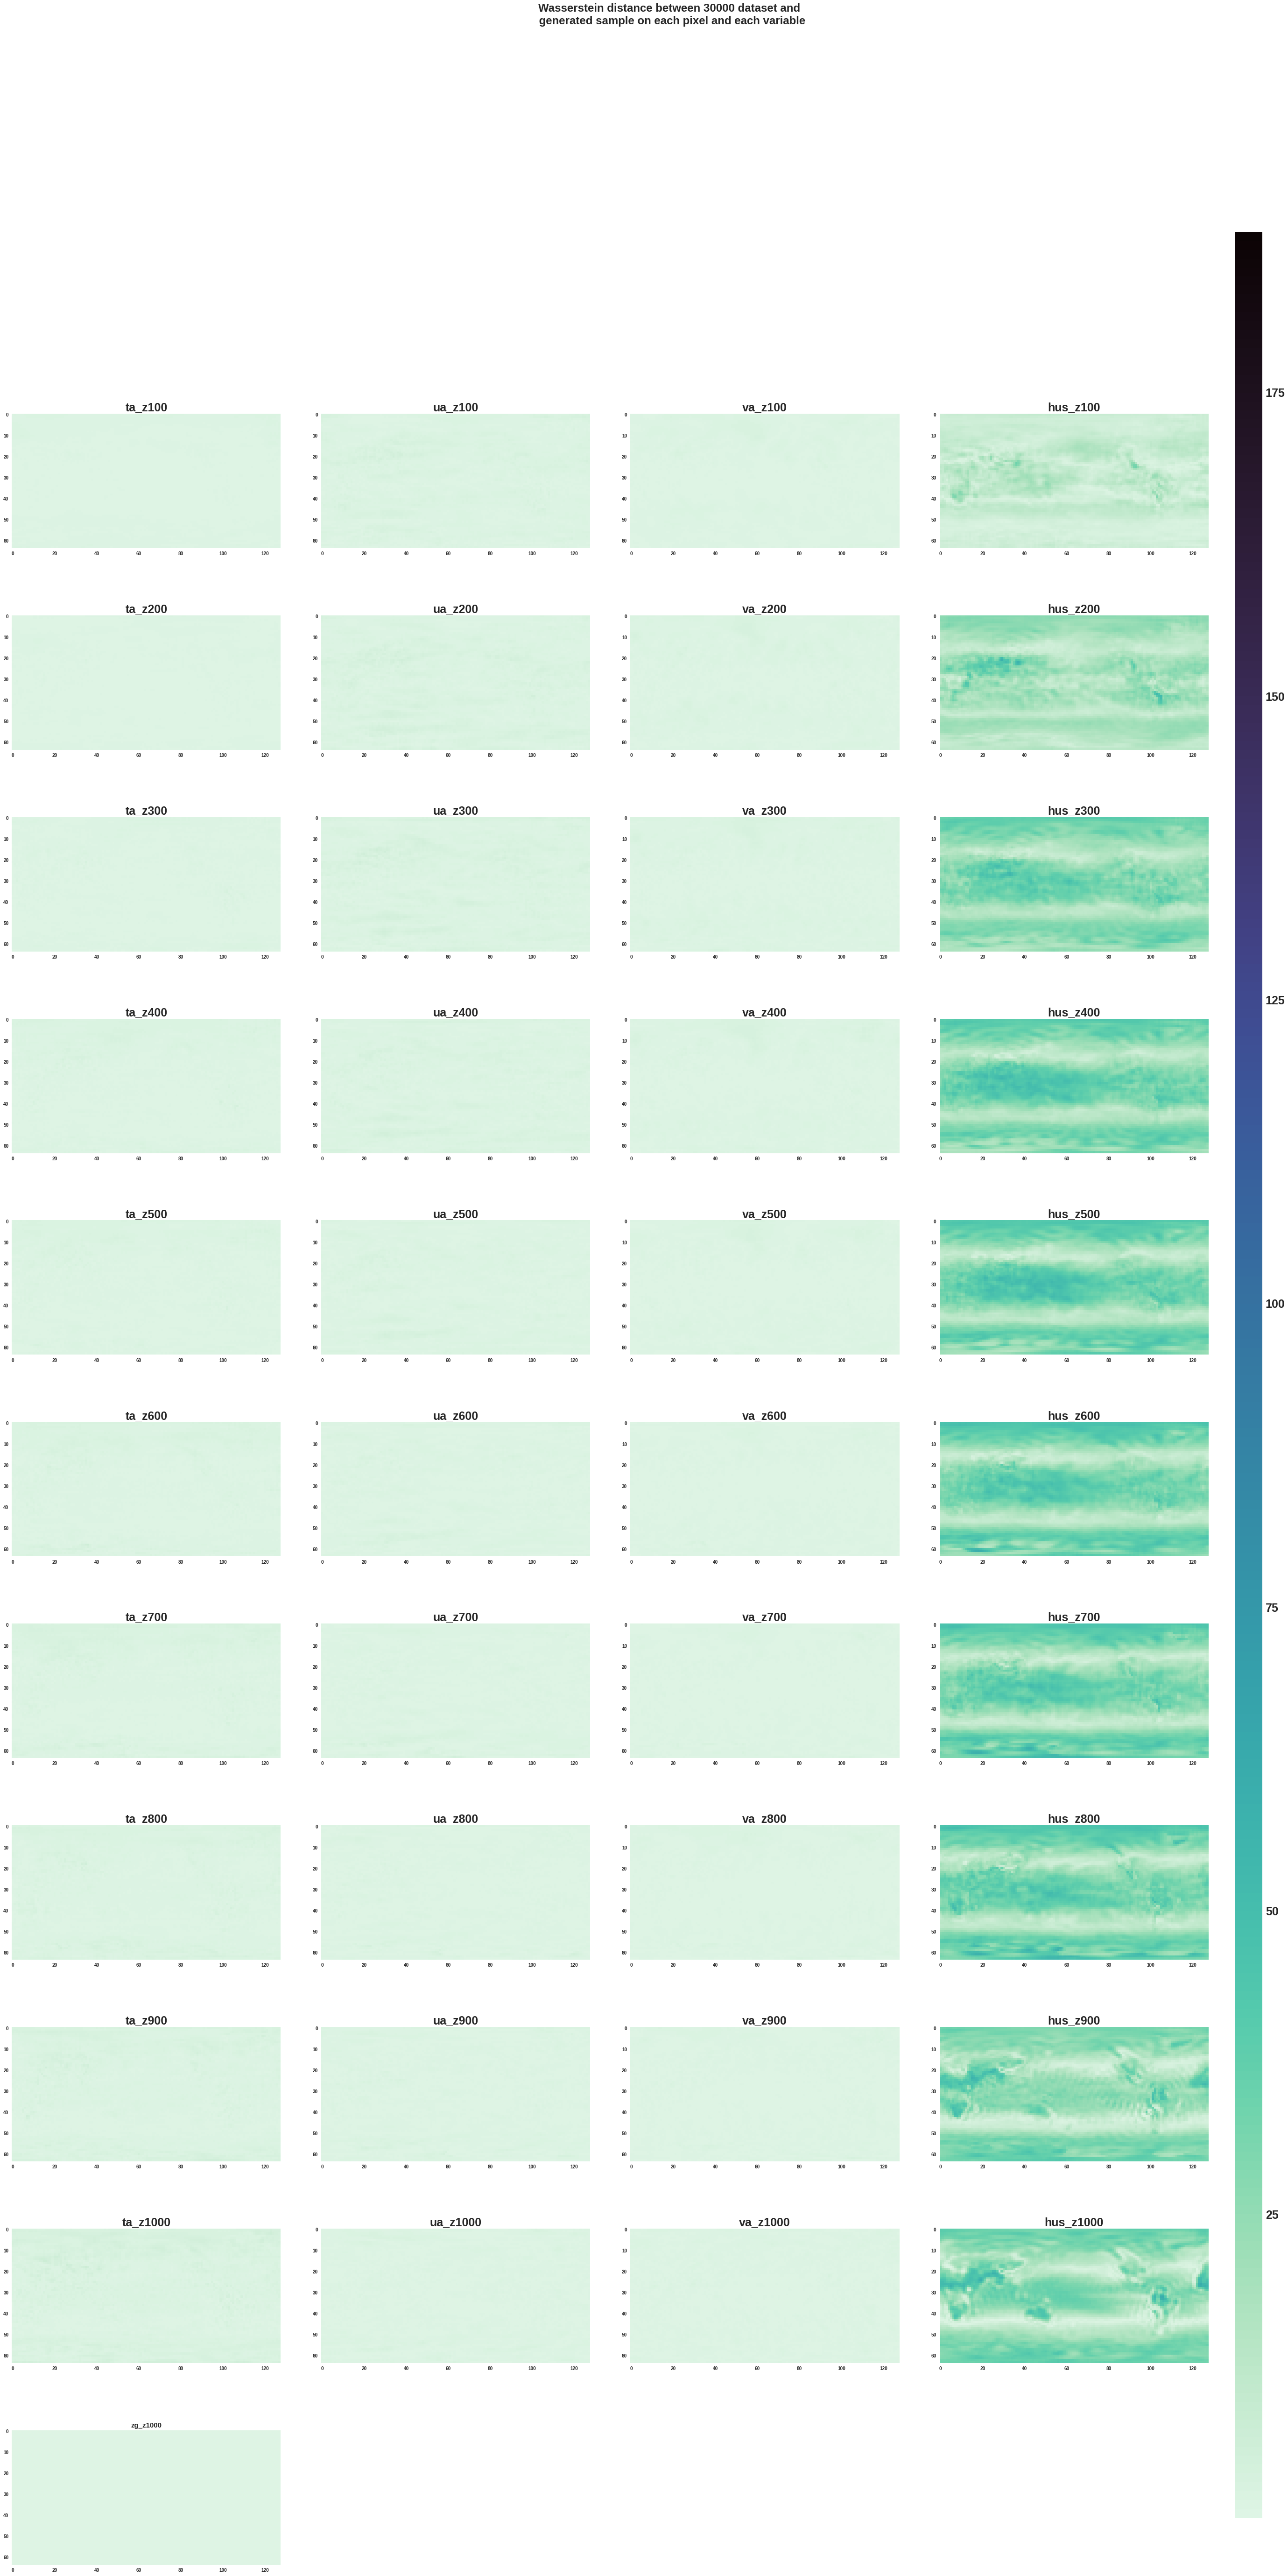

In [108]:
#lon = genfromtxt('/scratch/coop/besombes/Puma_Project/data/raw/lon.csv', delimiter=',')
#lat = genfromtxt('/scratch/coop/besombes/Puma_Project/data/raw/lat.csv', delimiter=',')
#np.save('./fig_82c/wd_im_82', wd_im)

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(nrows = N_lvls+1, ncols = 4, figsize=(40,85))

ax = ax.reshape(1,-1)
fig.suptitle(f'Wasserstein distance between 30000 dataset and \n generated sample on each pixel and each variable',
             fontsize = 24, fontweight = fontweight)
fig.subplots_adjust(top = 0.84,left=0.01,right=.9,bottom=0.08, wspace = 0.15, hspace = 0.3)
cnt = 0
cbar_max = np.amax(wd_im)
cbar_min = np.amin(wd_im)   
print(cbar_min, cbar_max)
for k in range(N_lvls):
    im =  ax[0,k*4+0].imshow(wd_im[:,:,k+0*N_lvls], cmap='mako_r', vmin=cbar_min, vmax=cbar_max)
    im =  ax[0,k*4+1].imshow(wd_im[:,:,k+1*N_lvls], cmap='mako_r', vmin=cbar_min, vmax=cbar_max)
    im =  ax[0,k*4+2].imshow(wd_im[:,:,k+2*N_lvls], cmap='mako_r', vmin=cbar_min, vmax=cbar_max)
    im =  ax[0,k*4+3].imshow(wd_im[:,:,k+3*N_lvls], cmap='mako_r', vmin=cbar_min, vmax=cbar_max)
    #im =  ax[0,k*N_lvls+4].imshow(wd_im[0,:,:,k+4*N_lvls], cmap='mako_r', vmin=cbar_min, vmax=cbar_max)
    #im =  ax[0,k+2*N_lvls].imshow(wd_im[0,:,:,k], cmap='mako_r', vmin=cbar_min, vmax=cbar_max)
    ax[0,k*4+0].set_title(chan_titles[k+0*N_lvls], fontsize = 25, fontweight = fontweight)
    ax[0,k*4+1].set_title(chan_titles[k+1*N_lvls], fontsize = 25, fontweight = fontweight)
    ax[0,k*4+2].set_title(chan_titles[k+2*N_lvls], fontsize = 25, fontweight = fontweight)
    ax[0,k*4+3].set_title(chan_titles[k+3*N_lvls], fontsize = 25, fontweight = fontweight)
    #ax[0,k*N_lvls+4].set_title(chan_titles[k+3*N_lvls], fontsize = 25, fontweight = fontweight)
    #ax[0,cnt-1].coastlines()

    ax[0,k*4+0].grid(False)
    ax[0,k*4+1].grid(False)
    ax[0,k*4+2].grid(False)
    ax[0,k*4+3].grid(False)
    
    cnt+=1



ax[0,-1].remove()
ax[0,-2].remove()
ax[0,-3].remove()

ax[0,-4].grid(False)
ax[0,-4].imshow(wd_im[:,:,-1], cmap='mako_r', vmin=cbar_min, vmax=cbar_max)
ax[0,-4].set_title(chan_titles[-2], fontsize = 15, fontweight = fontweight)
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
fig.colorbar(im, cax, orientation='vertical')
cax.tick_params(axis='both', which='major', labelsize=25)

if save:
    plt.savefig(f'./fig_{N_fields}c/wdistance_channels.pdf')   
#plt.tight_layout()    
#plt.show()

(64, 128, 81)
[2.98093415e-07 4.38763566e+01]


/home/besombes/.env/old_tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


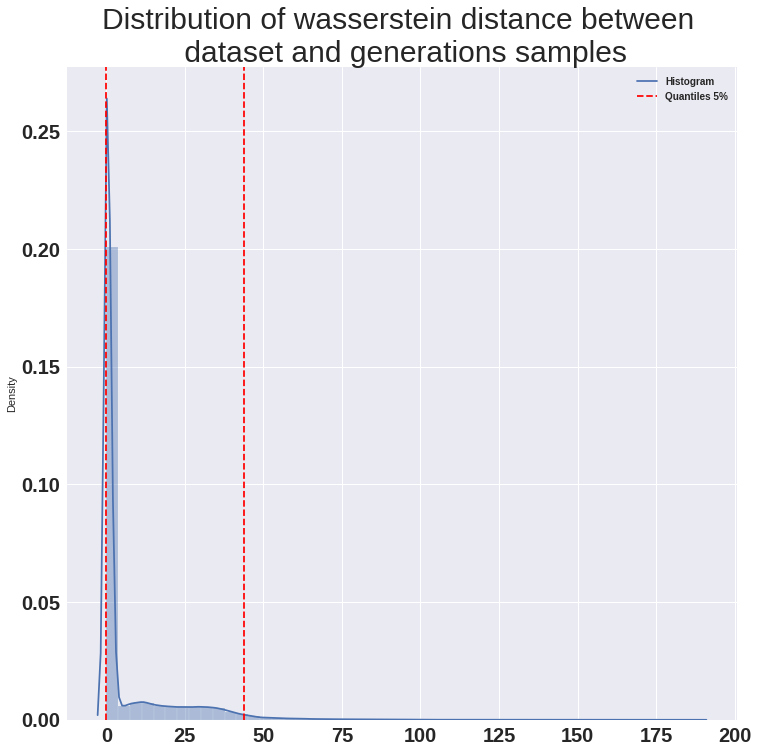

In [109]:
wd_flat = wd_im.reshape(1,-1)
print(wd_im.shape)
q = np.quantile(wd_flat, [0.025, 0.975])
print(q)

plt.figure(figsize = (12,12))
plt.title('Distribution of wasserstein distance between \n dataset and generations samples', fontsize = 30)
sns.distplot(wd_flat)
plt.axvline(q[0], color = 'red', linestyle = '--')
plt.axvline(q[1], color = 'red', linestyle = '--')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(['Histogram', 'Quantiles 5%'])

if True:
    plt.savefig(f'./fig_{N_fields}c/dist_wd_qt.pdf')

In [110]:
print(lvls)
print(var)
lvl_idx = np.array(wd_im, dtype = str)
for i in range(len(lvls)):
    lvl_idx[:,:,i::N_lvls] = f'z{str(lvls[i])}'
print(lvl_idx[:,:,0])
lvl_idx[:,:,-1] = 'z1000'


var_idx = np.array(wd_im, dtype = str)
for i in range(len(var)):
    var_idx[:,:,i*N_lvls:(i+1)*N_lvls] = f'{var[i]}'

var_idx[:,:,-1] = 'ps'
print(var_idx[0,0,:])
print(var_idx.shape)
print(lvl_idx.shape)
print(wd_im.shape)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
['ta', 'ua', 'va', 'hus', 'wap', 'zeta', 'd', 'zg']
[['z100' 'z100' 'z100' ... 'z100' 'z100' 'z100']
 ['z100' 'z100' 'z100' ... 'z100' 'z100' 'z100']
 ['z100' 'z100' 'z100' ... 'z100' 'z100' 'z100']
 ...
 ['z100' 'z100' 'z100' ... 'z100' 'z100' 'z100']
 ['z100' 'z100' 'z100' ... 'z100' 'z100' 'z100']
 ['z100' 'z100' 'z100' ... 'z100' 'z100' 'z100']]
['ta' 'ta' 'ta' 'ta' 'ta' 'ta' 'ta' 'ta' 'ta' 'ta' 'ua' 'ua' 'ua' 'ua'
 'ua' 'ua' 'ua' 'ua' 'ua' 'ua' 'va' 'va' 'va' 'va' 'va' 'va' 'va' 'va'
 'va' 'va' 'hus' 'hus' 'hus' 'hus' 'hus' 'hus' 'hus' 'hus' 'hus' 'hus'
 'wap' 'wap' 'wap' 'wap' 'wap' 'wap' 'wap' 'wap' 'wap' 'wap' 'zeta' 'zeta'
 'zeta' 'zeta' 'zeta' 'zeta' 'zeta' 'zeta' 'zeta' 'zeta' 'd' 'd' 'd' 'd'
 'd' 'd' 'd' 'd' 'd' 'd' 'zg' 'zg' 'zg' 'zg' 'zg' 'zg' 'zg' 'zg' 'zg' 'zg'
 'ps']
(64, 128, 81)
(64, 128, 81)
(64, 128, 81)


In [111]:
cm = ['rocket','rocket','rocket','rocket','rocket','rocket','Blues','Blues','Blues','Purples','Purples','Purples',
      'PuRd','PuRd','PuRd','copper','copper','copper','viridis','viridis','viridis',
      'Greens_r','Greys']

index = wd_im.shape
print(index)
d = {'var': var_idx.reshape(-1),
     'val': wd_im.reshape(-1),
     'lvl': lvl_idx.reshape(-1)}

sta = pd.Series(d)
df_wd = pd.DataFrame(data = d, index = np.arange(index[0]*index[1]*index[2]))
df_wd.head()



(64, 128, 81)


,var,val,lvl
0,ta,1.425118,z100
1,ta,0.482138,z200
2,ta,0.695467,z300
3,ta,2.064762,z400
4,ta,1.363764,z500


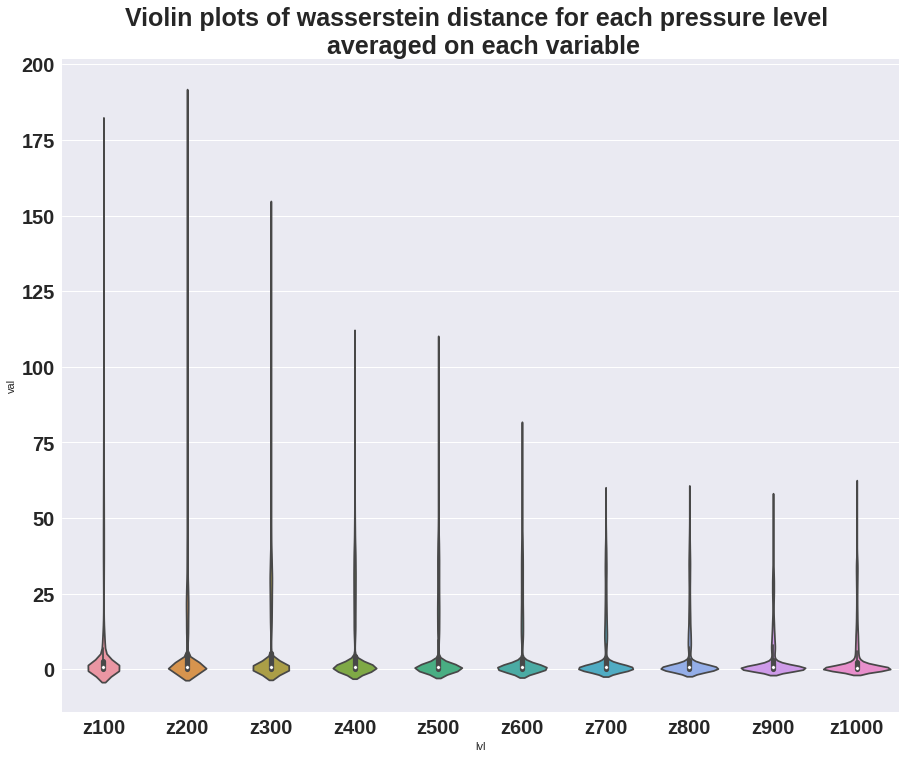

In [112]:
plt.figure(figsize = (15,12))
sns.violinplot(x="lvl", y="val", data=df_wd)
plt.title('Violin plots of wasserstein distance for each pressure level \n averaged on each variable', fontsize = 25, fontweight = 'bold')

plt.tick_params(axis='both', labelsize=tick_size)

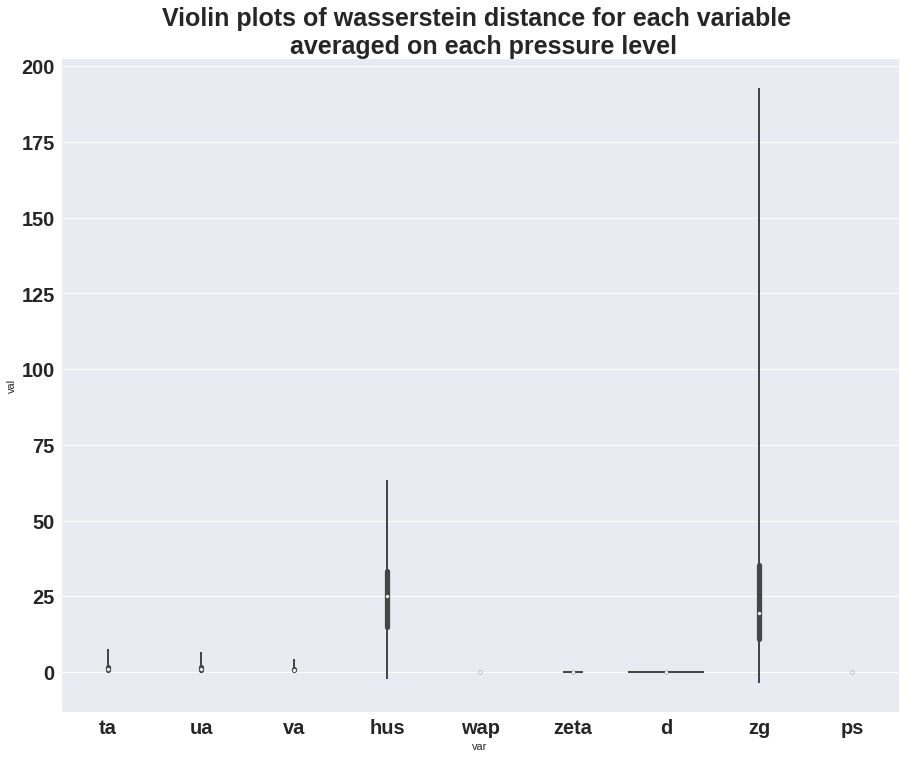

In [113]:
plt.figure(figsize = (15,12))
sns.violinplot(x="var", y="val", data=df_wd)
plt.title('Violin plots of wasserstein distance for each variable \n averaged on each pressure level', fontsize = 25, fontweight = 'bold')
plt.tick_params(axis='both', labelsize=tick_size)
plt.savefig(f'./fig_{N_fields}c/dist_wd_vars.pdf')

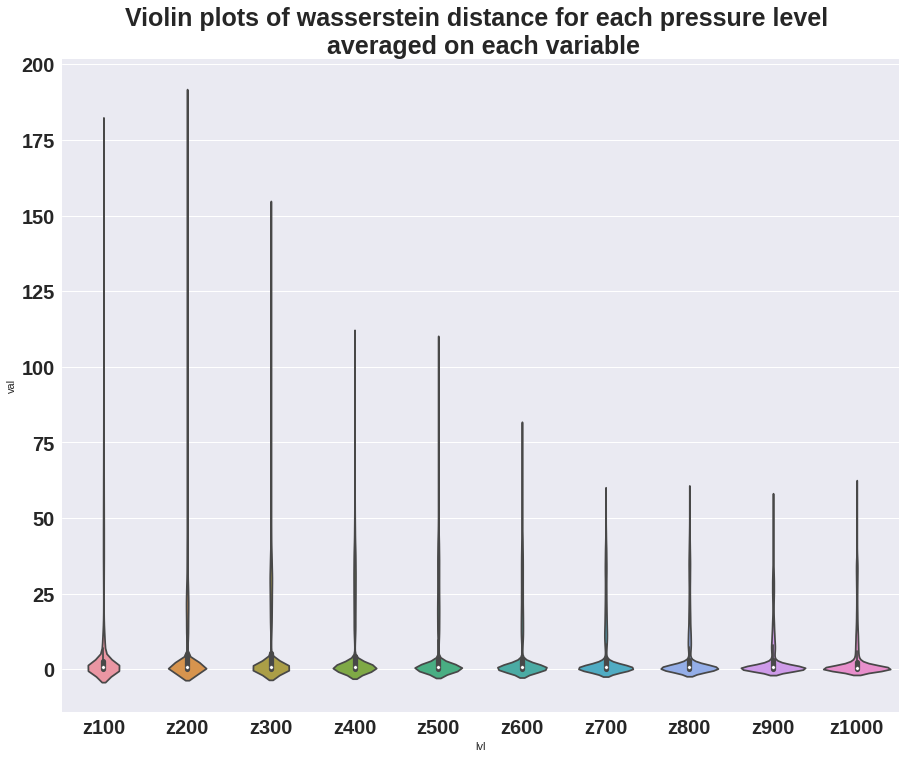

In [114]:
plt.figure(figsize = (15,12))
sns.violinplot(x="lvl", y="val", data=df_wd)
plt.title('Violin plots of wasserstein distance for each pressure level \n averaged on each variable', fontsize = 25, fontweight = 'bold')

plt.tick_params(axis='both', labelsize=tick_size)



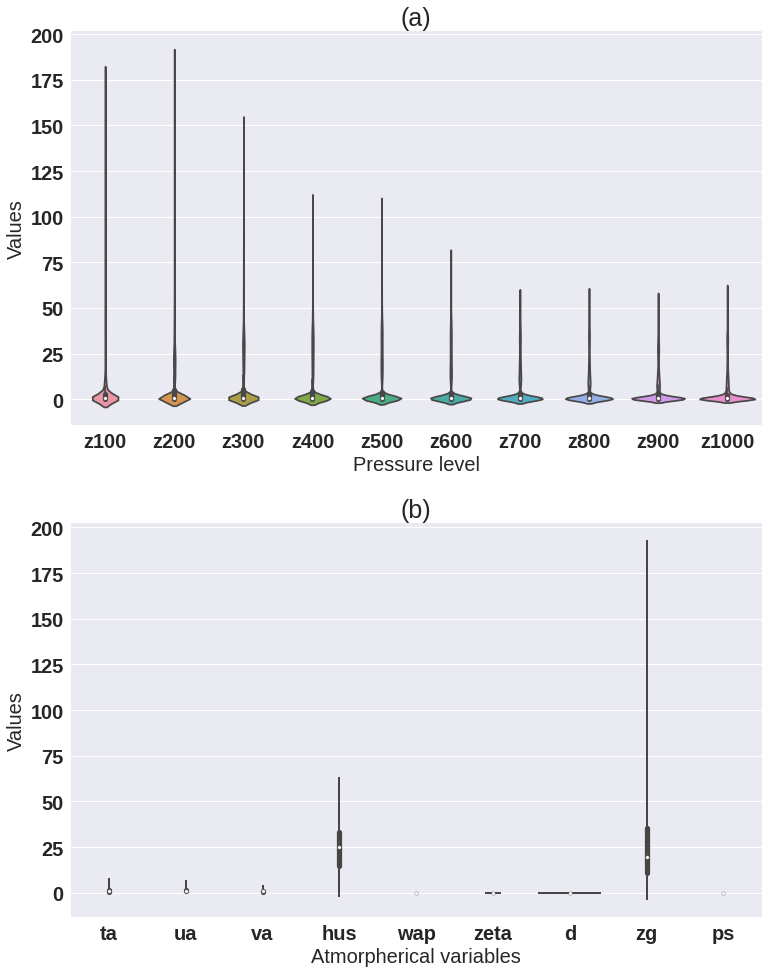

In [115]:
fig, ax = plt.subplots(2,1, figsize = (12,15))
fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.05, hspace = 0.25)

ax[0].set_title('(a)', fontsize = 25)
sns.violinplot(x="lvl", y="val", data=df_wd, ax = ax[0])
ax[0].set_xlabel('Pressure level', fontsize = 20)
ax[0].set_ylabel('Values', fontsize = 20)
ax[0].tick_params(axis='both', labelsize=20)


sns.violinplot(x="var", y="val", data=df_wd, ax = ax[1])
plt.title('(b)', fontsize = 25)
ax[1].set_xlabel('Atmorpherical variables', fontsize = 20)
ax[1].set_ylabel('Values', fontsize = 20)
plt.tick_params(axis='both', labelsize=20)
plt.savefig(f'./fig_{N_fields}c/double_violin_plot.pdf')

In [116]:
wd_max = np.amax(wd_im)
print(wd_max)

idx_max = np.argwhere(wd_im==wd_max)
print((idx_max))

print(type(idx_max))

wd_min = np.amin(wd_im)
print(wd_min)

idx_min = np.argwhere(wd_im==wd_min)
print((idx_min))

print(type(idx_min))

188.23050685166436
[[19 29 71]]
<class 'numpy.ndarray'>
3.325808486687012e-08
[[63 38 60]]
<class 'numpy.ndarray'>


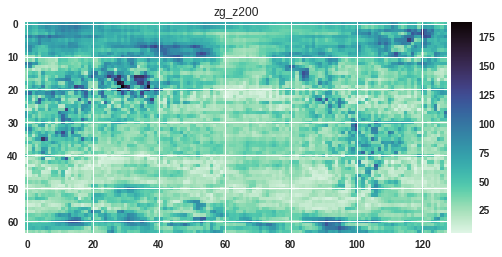

In [117]:
fig = plt.figure()
ax = plt.subplot(111)
im = plt.imshow(wd_im[:,:,idx_max[0][-1]], cmap = 'mako_r')
plt.title(chan_titles[idx_max[0][-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax = cax)

/home/besombes/.env/old_tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


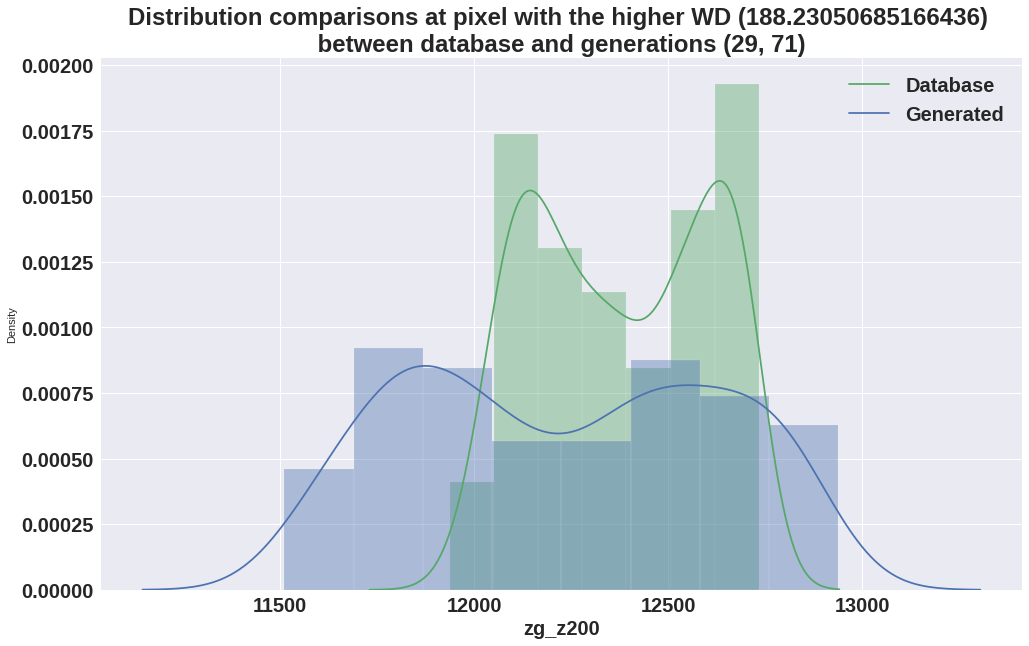

In [118]:
fig, ax = plt.subplots(figsize=(16,9))
plt.suptitle(f'Distribution comparisons at pixel with the higher WD ({wd_max}) \n between database and generations {idx_max[0][1], idx_max[0][2]} '
            , fontsize = 24, fontweight = fontweight)

fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.1, hspace = 0.3)

plt.subplot(1,1,1)
sns.distplot(X_train[:,idx_max[0][0], idx_max[0][1], idx_max[0][2]], rug=False, hist=True, kde = True,
             norm_hist = False, color = 'g', bins = None)


sns.distplot(fk_imgs[:,idx_max[0][0], idx_max[0][1], idx_max[0][2]], rug=False, hist=True, kde = True,
             norm_hist = False, color = 'b', bins = None)
plt.xlabel(chan_titles[idx_max[0][2]], fontsize = 20, fontweight = 'bold')
#plt.xlabel(var2plot[0][:-5], fontsize = 20, fontweight = fontweight)
plt.legend(['Database',"Generated" ], fontsize = 20)
plt.tick_params(axis='both', labelsize=tick_size)
if save:
    plt.savefig('./fig_82c/distrib_comp_high_wd.pdf')

/home/besombes/.env/old_tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


NameError: name 'lon' is not defined

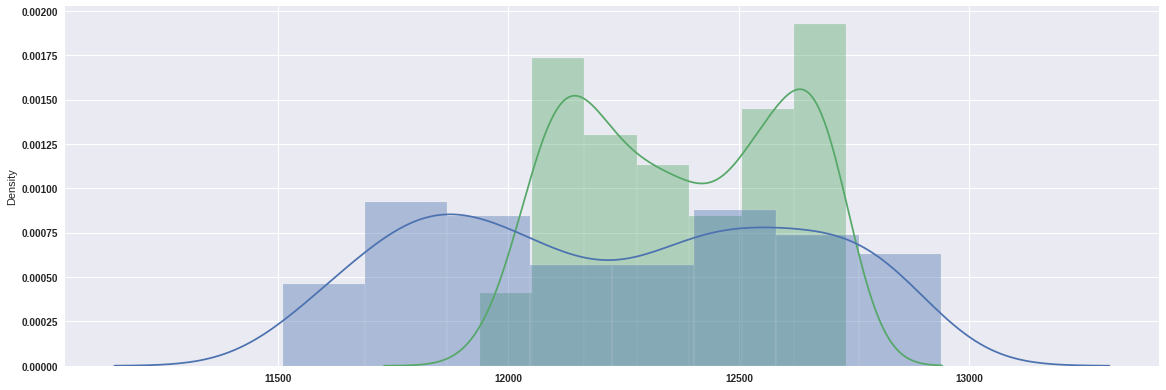

In [121]:
fig, ax = plt.subplots(figsize=(19,14))

fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.1, hspace = 0.3)

plt.subplot(2,1,1)
sns.distplot(X_train[:,idx_max[0][0], idx_max[0][1], idx_max[0][2]], rug=False, hist=True, kde = True,
             norm_hist = False, color = 'g', bins = None)


sns.distplot(fk_imgs[:,idx_max[0][0], idx_max[0][1], idx_max[0][2]], rug=False, hist=True, kde = True,
             norm_hist = False, color = 'b', bins = None)
plt.title(f'(a) \n Higher WD ({wd_max:.3}) pixel : ({lat[idx_max[0][0]]:.3}, {lon[idx_max[0][1]]:.3})'
            , fontsize = 24, fontweight = fontweight)

plt.xlabel(chan_titles[idx_max[0][2]], fontsize = 15, fontweight = 'bold')
#plt.xlabel(var2plot[0][:-5], fontsize = 20, fontweight = fontweight)
plt.legend(['Database',"Generated" ], fontsize = 20)
plt.tick_params(axis='both', labelsize=tick_size)

plt.subplot(2,1,2)
sns.distplot(X_train[:,idx_min[0][0], idx_min[0][1], idx_min[0][2]], rug=False, hist=True, kde = True,
             norm_hist = False, color = 'g', bins = None)


sns.distplot(fk_imgs[:,idx_min[0][0], idx_min[0][1], idx_min[0][2]], rug=False, hist=True, kde = True,
             norm_hist = False, color = 'b', bins = None)
plt.title(f'(b) \n Lower WD ({wd_min:.3}) pixel : ({lat[idx_min[0][0]]:.3}, {lons[idx_min[0][1]]:.3})'
            , fontsize = 24, fontweight = fontweight)
#plt.xlabel(var2plot[0][:-5], fontsize = 20, fontweight = fontweight)
#plt.legend(['Database',"Generated" ], fontsize = 20)
plt.tick_params(axis='both', labelsize=tick_size)
plt.xlabel(chan_titles[idx_min[0][2]], fontsize = 15, fontweight = 'bold')
plt.savefig('./fig_82c/higher_lower_wd.pdf')

In [ ]:
print(idx_min)
print(idx_max)
print(lat[idx_max[0][0]])
print(lat)